# 영수증 OCR 도전하기 
- 현재 네이버 플레이스에서 사용되고 있는 영수증 인식을 직접 이번 기회에 해보고 싶어서 예전에 사용했던 영수증 사진을 사용했다. 

### **루브릭 평가 기준**

|<center>평가문항</center>|<center>상세기준</center>|
|:------|:------|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|

이미지 경로 설정

In [1]:
import os

img_dir = os.getenv('HOME')+'/aiffel/ocr_python/Image'
receipts = os.listdir(img_dir)
receipts

['receipt5.jpg',
 'receipt2.jpg',
 'receipt4.jpg',
 'receipt6.jpg',
 'receipt1.jpg',
 'receipt3.jpg']

# 1. keras-ocr
- 한글 데이터셋으로 훈련이 되어있지 않은 모델입니다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의해 주세요.


In [2]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
images = [ keras_ocr.tools.read(os.path.join(img_dir, receipt)) for receipt in receipts]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, receipt)]) for receipt in receipts]

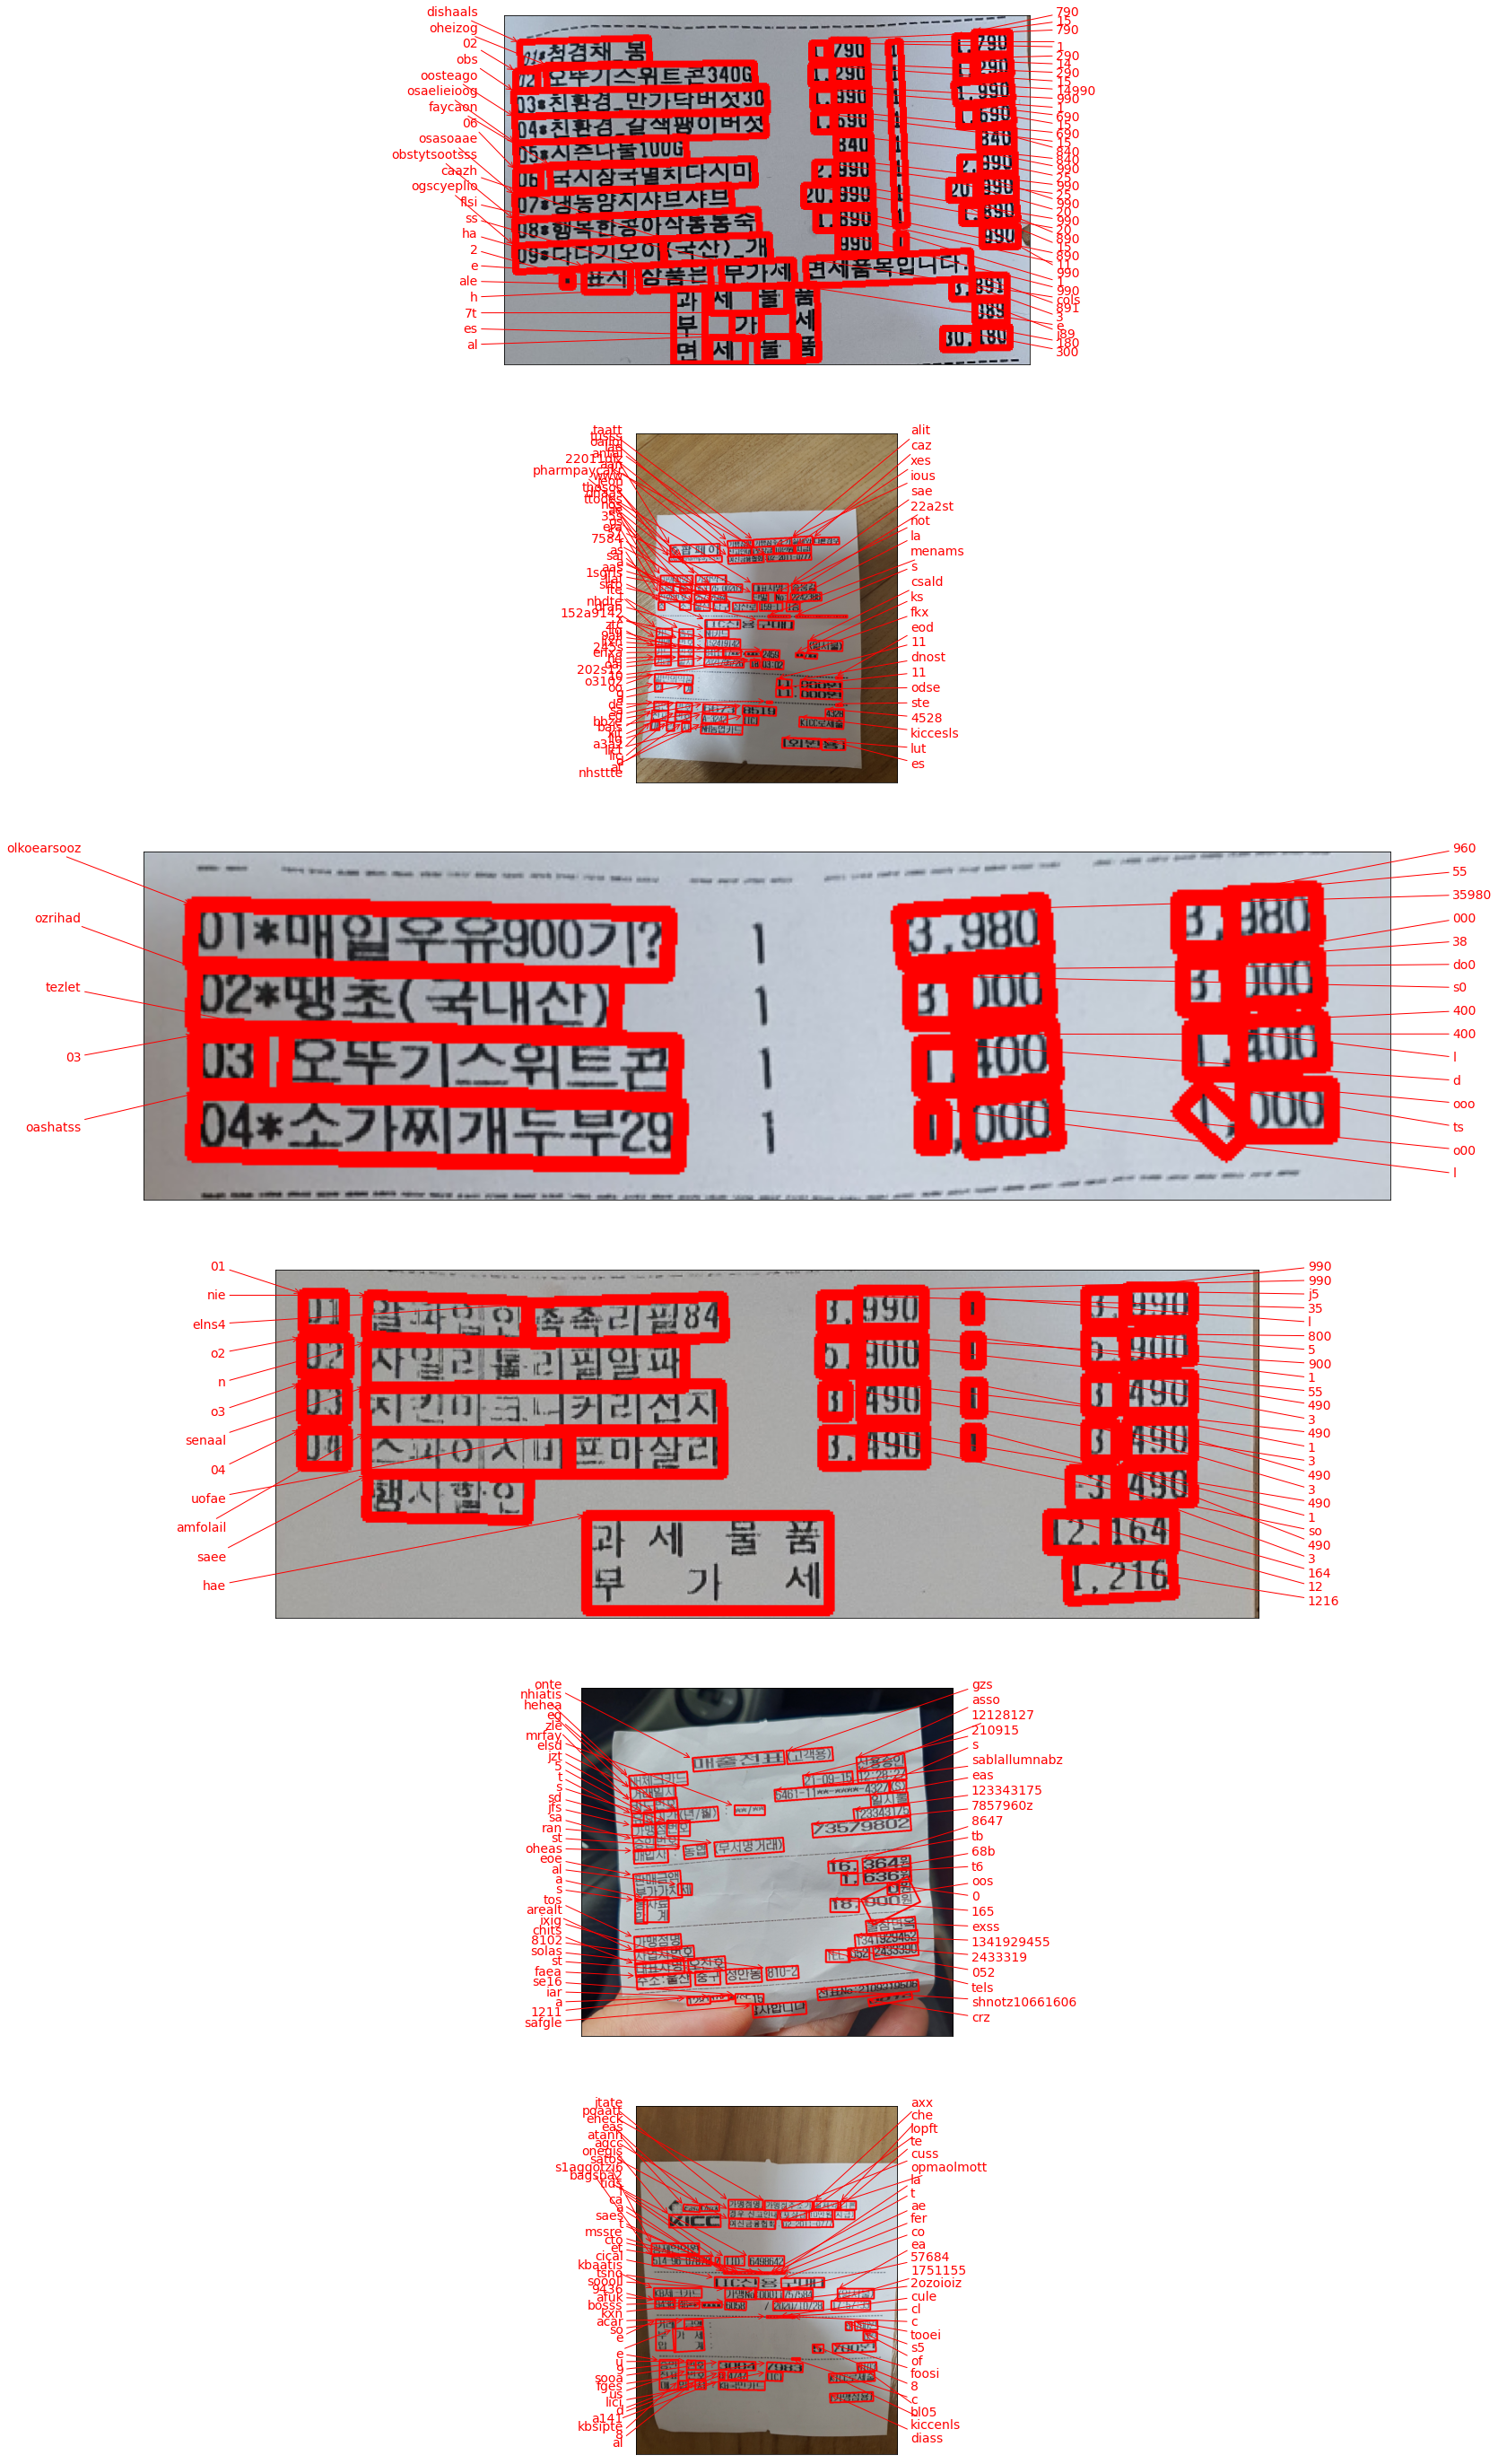

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

한글 데이터셋이 훈련되지 않아서 한글 인식은 되지 않고 숫자는 그나마 인식을 하지만 정확하게 딱 맞지는 않은 것을 볼 수 있다. 바운딩 박스는 잘 검출되는 모습을 보이지만 문자를 인식하는 과정에서 한글이므로 제대로 이루어지지 않은 것을 볼 수 있다. 

# 2. Tesseract test

테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


테서랙트로 잘린 이미지에서 단어 인식하기

In [6]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/Image'
img_file_path = work_dir + '/receipt4.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/Image/0000.png
/aiffel/aiffel/ocr_python/Image/0001.png
/aiffel/aiffel/ocr_python/Image/0002.png
/aiffel/aiffel/ocr_python/Image/0003.png
/aiffel/aiffel/ocr_python/Image/0004.png
/aiffel/aiffel/ocr_python/Image/0005.png
/aiffel/aiffel/ocr_python/Image/0006.png
/aiffel/aiffel/ocr_python/Image/0007.png
/aiffel/aiffel/ocr_python/Image/0008.png
/aiffel/aiffel/ocr_python/Image/0009.png
/aiffel/aiffel/ocr_python/Image/0010.png
/aiffel/aiffel/ocr_python/Image/0011.png


위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.

In [9]:
recognize_images(cropped_image_path_list)

014

매

1입<

구누


000

느

1?

주



1100

Done


- 4번 영수증의 경우 매일우유, 떙초, 오뚜기스위트콘, 소가찌개두부29가 있는데 글자가 잘려서 제대로 인식되지 못한 것을 볼 수 있고, 영수증 자체의 글자가 명확하지 않으면 제대로 인식하지 못하는 것을 볼 수 있었다. 일 글자가 입처럼 보여서 인식 또한 입으로 인식 되었다. 한글 또한 제대로 인식되지 않는 것을 볼 수 있다. 

# 3. Google Cloud Vision API 사용

In [10]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [12]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/Image/receipt4.jpg'
  

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

Texts:

"01*매일우유900기? 1 3,980
3,980
3,000
1,400
1,000
02*땡초(국내산)
3,000
1,400
1,000
1
03 오뚜기스위트콘
1
04*소가찌개두부29
"

"01"

"*"

"매일"

"우유"

"900"

"기"

"?"

"1"

"3,980"

"3,980"

"3,000"

"1,400"

"1,000"

"02"

"*"

"땡초"

"("

"국내산"

")"

"3,000"

"1,400"

"1,000"

"1"

"03"

"오뚜기"

"스위트"

"콘"

"1"

"04"

"*"

"소"

"가"

"찌개"

"두부"

"29"
bounds: (205,109),(228,109),(227,138),(204,138)


In [14]:
# 입력 이미지 경로를 지정해 주세요.
path2 = os.getenv('HOME')+'/aiffel/ocr_python/Image/receipt5.jpg'
  

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path2)

Texts:

"012첨경채_봉
1,790 1 1,790
1,290 1 1,290
1,990 1 1,990
1,690 1 1,690
840 1
2,990 1 2,990
20,990 1 20,990
1,890 1 1,890
990 1
02 오뚜기스위트콘340G
03* 친환겸_만가닥버섯30
04*친환겸_갈색팽이버섯
05*시즌나물100G
840
06 국시장국멸치다시마
07*냉동양지샤브샤브
08* 햄복한콩아삭통통숙
09*다다기오이(국산)_개
990
# 표시 삼품은 부가세 면세품목입니다.
3,891
389
30,180
과 세 물품
부
가 세
면세 물 품
"

"012"

"첨"

"경채"

"_"

"봉"

"1,790"

"1"

"1,790"

"1,290"

"1"

"1,290"

"1,990"

"1"

"1,990"

"1,690"

"1"

"1,690"

"840"

"1"

"2,990"

"1"

"2,990"

"20,990"

"1"

"20,990"

"1,890"

"1"

"1,890"

"990"

"1"

"02"

"오뚜기"

"스위트"

"콘"

"340G"

"03"

"*"

"친환"

"겸"

"_"

"만"

"가닥"

"버섯"

"30"

"04"

"*"

"친환"

"겸"

"_"

"갈색"

"팽이"

"버섯"

"05"

"*"

"시즌"

"나물"

"100G"

"840"

"06"

"국시"

"장국"

"멸치"

"다시마"

"07"

"*"

"냉동"

"양지"

"샤브샤브"

"08"

"*"

"햄"

"복한"

"콩"

"아삭"

"통통"

"숙"

"09"

"*"

"다다기"

"오이"

"("

"국산"

")"

"_"

"개"

"990"

"#"

"표시"

"삼품"

"은"

"부가세"

"면세"

"품목"

"입니다"

"."

"3,891"

"389"

"30,180"

"과"

"세"

"물품"

"부"

"가"

"세"

"면세"

"물"

"품"
bounds: (294,315),(3

### 역시 구글 성능 확실

# 회고
1. 처음에는 영수증 긴 상태로 사용하였는데 글자에 숫자까지 인식되다보니 너무 빽빽해서 영수증 사진을 좀 줄이고 해보기로 함
2. 결제 수단에서 <<카드 세부정보 중 일부가 잘못되었습니다. [OR-KCCSEH-11]>> 라고 계속 에러가 떠서 구글에도 문의하고 구글링도 했지만 고칠 수 없었다. 결제 수단에 등록이 되어야 뒤의 과정이 진행 되는데 거기서 막혀서 동생 구글 계정으로도 시도해보았지만 제대로 되지 않아 구글 API는 못 해보겠다고 포기했었다. 그런데 구연님이 새로운 계정으로 해서 실행하셨다는 얘기를 듣고 원래 사용하는 계정이 아닌 다른 계정으로 들어가서 해봐서 드디어 성공했다. 완전 소리 질렀다 와우!!!!!!!!!!!!
3. 역시 구글 API를 사용하니 성능 확실하다. 살짝 ㅇ을 ㅁ으로 오타가 보이기는 하지만 대부분 잘 인식된 것을 볼 수 있었다. 구글 API 사용해서 확인할 수 있어서 좋았고, 네이버 플레이스 또한 이런 원리로 글자를 인식했겠구나 생각이 들었다. 영수증 인식할 때 주소가 인식이 안되면 영수증 등록이 되지 않는데 그때 사용자가 직접 주소를 입력시켜서 인식이 안된 부분의 정답을 알려주는 방식으로 진행하는 것을 볼 수 있다. 계속 그런 데이터들이 쌓이면 영수증에 가끔 깨지거나 흐려서 잘 보이지 않는 부분도 예측률을 높여서 더 정확한 OCR 모델이 될 수 있는 것 같다. 
4. 이번 익스는 구글 API 때문에 진짜 스트레스였지만 구글 API의 높은 정확도를 볼 수 있어서 마무리는 좋았다. 